# QC Sweep


In [1]:
import numpy as np
import pdb
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker

In [2]:
import warnings
warnings.simplefilter("ignore",UserWarning)

In [3]:
import mitonetworks.det as mtd
import mitonetworks.stoch as mts

In [4]:
mts.reset_plots()

In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
mtd.reset_plots()

## Parameter definition

In [6]:
params = {
    'beta':33.12, 
    'gamma':0.03785142857142858,
    'b':1.2416523075924095e-05, 
    'kappa':11.662903457629223,
    'mu':0.023, 
    'xi':0.0, 
    'delta':1.0
}

gamma_nom = params['gamma']

In [7]:
epsilon_space = np.linspace(-5,-0.5,10)
Q_space = 1.0 + 10**epsilon_space
Q_space = 1./np.hstack(([1], Q_space)) # NB: det code uses opposite convention to avoid performing division

In [8]:
n_points = 21
lg_ls_low_gamma = -2
lg_ls_high_gamma = 2
gamma_space = 10**np.linspace(lg_ls_low_gamma,lg_ls_high_gamma,n_points) # gamma space
gamma_labels = np.log10(gamma_space)

In [9]:
deltah_arr = np.zeros((len(gamma_space),len(Q_space)))

In [10]:
make_data = False

In [11]:
T_measure = 1000.0

In [12]:
def get_delta_h(params):
    # Get ICs
    lc = mts.SubmitHPCSoluableFeedbackControl(ss_definition=mtd.E_linear_feedback_control_ss,nominal_params=params,
                                         hpc_workdir=None,c_filename=None,c_file_param_ordering_convention=None,hpc_jobname=None)
    ics, h, e = lc.find_ss_h_target(lc.nominal_params)
    if h is not np.nan:
        # Simulate ODEs
        lc = mtd.FeedbackControl(network_defn=mtd.E_linear_feedback_control, params=params, initial_state=ics, TMAX = T_measure)   
        initial_h = (ics[2]+ics[3])/float(np.sum(ics))
        lc.make_trajectory()
        final_state = lc.state
        final_h = (final_state[2]+final_state[3])/float(np.sum(final_state))
        delta_h = final_h - initial_h
        return delta_h
    else:
        raise Exception('Error')

In [13]:
if make_data:
    for i, gamma_change in enumerate(gamma_space):
        print(i)
        for j, newQ in enumerate(Q_space):
            # Update params
            newgamma = gamma_nom * gamma_change 
            params['gamma'] = newgamma
            params['Q_f'] = newQ                
            deltah_arr[i,j] = get_delta_h(params)            
        np.save('deltah_arr',deltah_arr)        

In [14]:
deltah_arr = np.load('deltah_arr.npy')

In [15]:
deltah_arr[deltah_arr==0] = np.nan

In [16]:
from pdb import set_trace

In [17]:
def cast_as_1sf_str(X):
    return ["%.1f" % x for x in X]
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [18]:
eps_labels = [r'$\epsilon_f=0$'] + [str(x) for x in epsilon_space]

In [19]:
cmap = cm.coolwarm
cmap.set_bad(color='0.75')

/home/juvid/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


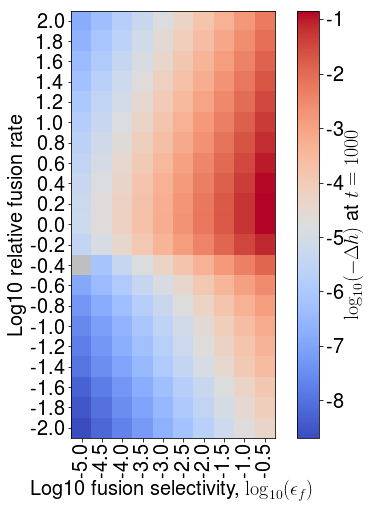

In [20]:
fig, ax = plt.subplots(1,1, figsize = (9,7.5))
im00 = ax.imshow(np.flipud(np.log10(-deltah_arr[:,1:])),cmap = cmap, interpolation='none')
plt.colorbar(im00, ax=ax, fraction=0.046,pad=0.04,
             label="$\log_{{10}}(-\Delta h)$ at $t={:d}$".format(int(T_measure)),format='%1.0f')
ax.set_xlabel(r'Log10 fusion selectivity, $\log_{10}(\epsilon_f)$')
ax.set_ylabel(r'Log10 relative fusion rate')
ax.set_xticks(range(len(Q_space[1:])));
ax.set_yticks(range(len(gamma_space)));
ax.set_xticklabels(eps_labels[1:], rotation = 90);
ax.set_yticklabels(cast_as_1sf_str(gamma_labels[::-1]));
plt.tight_layout()
plt.savefig('dh_sel_fus.svg')

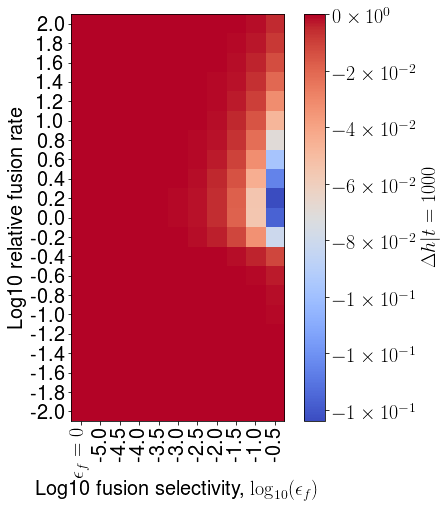

In [21]:
fig, ax = plt.subplots(1,1, figsize = (9,7.5))
im00 = ax.imshow(np.flipud(deltah_arr),cmap = cm.coolwarm, interpolation='none')
plt.colorbar(im00, ax=ax, fraction=0.046,pad=0.04,label="$\Delta h|t={:d}$".format(int(T_measure)),format=ticker.FuncFormatter(fmt))
ax.set_xlabel(r'Log10 fusion selectivity, $\log_{10}(\epsilon_f)$')
ax.set_ylabel(r'Log10 relative fusion rate')
ax.set_xticks(range(len(Q_space)));
ax.set_yticks(range(len(gamma_space)));
ax.set_xticklabels(eps_labels, rotation = 90);
ax.set_yticklabels(cast_as_1sf_str(gamma_labels[::-1]));
plt.tight_layout()